HSE, Applied Time Series Forecasitng , Winter 2024-25

<font color="green"> Lesson #10: TS Segmentation approaches</font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**
    - Time Series Segmentation, TS Clustering, Intermittency Test, Seasonality Test, ABC-classification

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# don't forget to upload utils file to the colab session
import warnings

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# Time Series Segmentation: Overview

**Question**
 * What is the purpose of TS segmenation? What TS can we call as "similar"?
   - Two time series are similar if they have about the same level (mean) value
   - Two time series are similar if they have the same hidden component (trend, seasonality, intermittency)



# Clustering based on Demand Behaviour to define ML Training pipeline
**Question:** How to split all timeseries with about the same structure?

*Idea: apply clustering algorithms to lagged features.



In [16]:
# Loading data
ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], format= "%Y-%m-%d") #dayfirst=True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail = ts_retail.sort_index() # must have
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-01,19,1,NaN,25.0,163.78,NaN
2015-01-01,39,2,NaN,3.0,135.78,NaN
2015-01-01,40,2,NaN,0.0,135.78,NaN
2015-01-01,18,1,NaN,13.0,163.78,NaN


<Axes: xlabel='Date'>

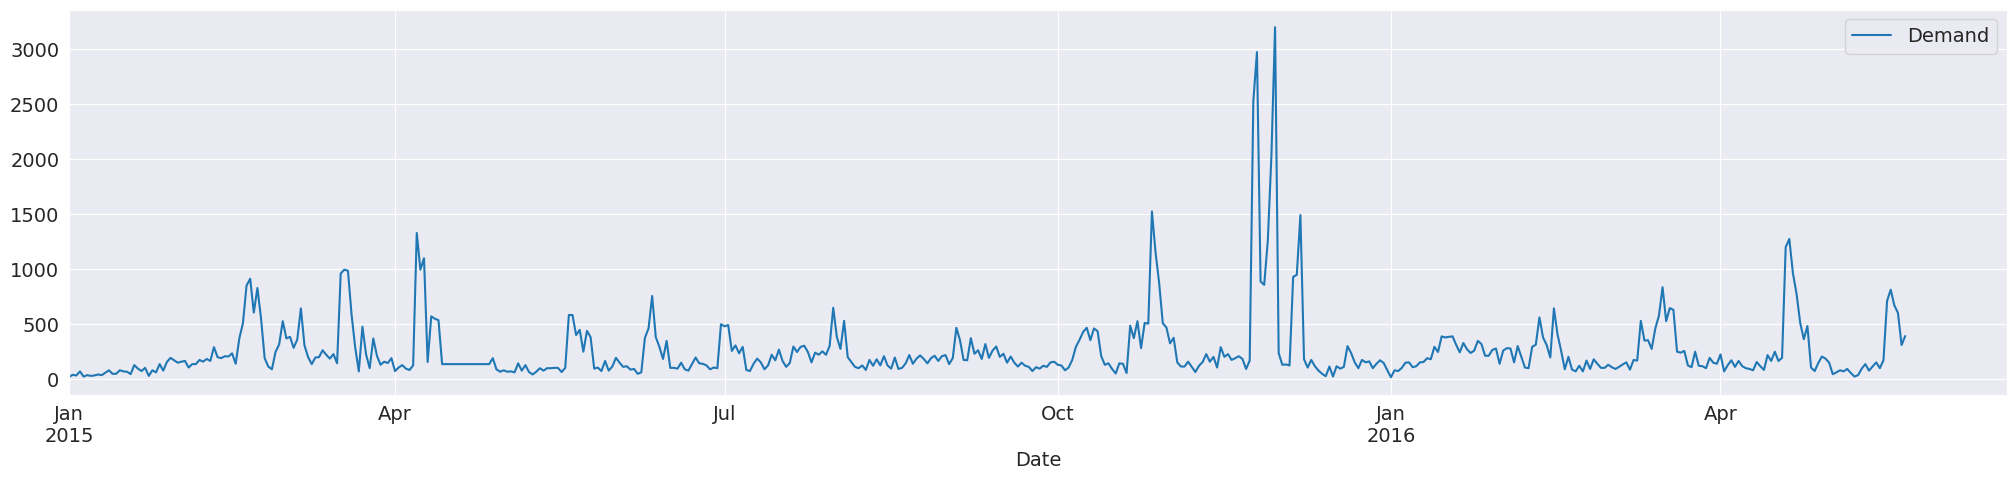

In [5]:
ts_retail[(ts_retail['SKU_id']==1) & (ts_retail['Store_id']==1)][['Demand']].plot()

In [6]:
len(ts_retail['Store_id'].unique())

110

In [ ]:
top_sum = ts_retail.groupby('SKU_id').sum()[['Demand']]
top_sum['percent'] = top_sum['Demand']/top_sum['Demand'].sum()
top_SKU = list((top_sum['percent'] >= 0.01).index)
demand_top_sku = ts_retail.index
# # [ SKU in top_SKU for SKU in ts_retail['SKU_id'] ]
demand_top_sku_pivot = pd.pivot_table(ts_retail.groupby(['SKU_id', 'Store_id']).mean()['Demand'].reset_index(),
                                      index='Store_id', values='Demand', columns='SKU_id', fill_value=0).rename_axis(None, axis=1)
demand_top_sku_pivot


,1,2
Store_id,,
1,260.531496,14.726378
2,625.015748,19.470472
3,378.708661,9.431102
4,422.751969,10.895669
5,570.673228,18.431102
...,...,...
99,378.585106,7.500000
100,173.166667,22.333333
104,188.791667,4.291667


In [7]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

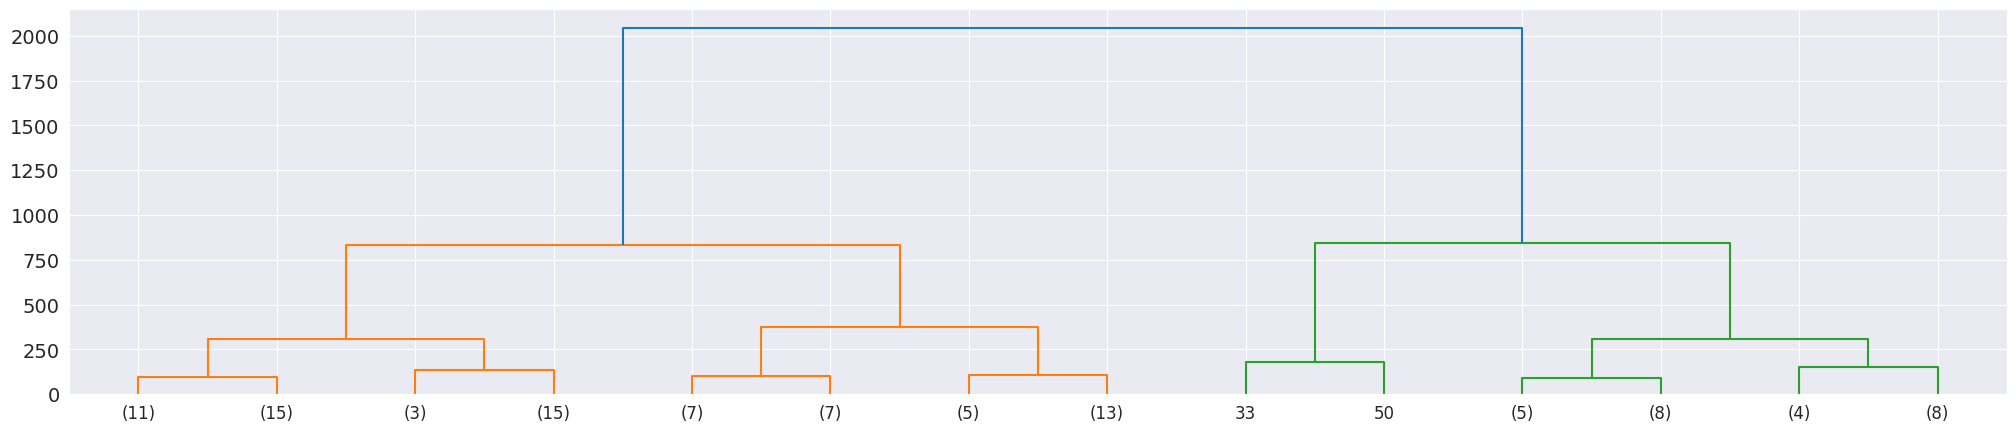

In [8]:
# for SKU in ts_retail['SKU_id'].unique():
# select TOP SKU (in case there are a lot of SKU)
top_sum = ts_retail.groupby('SKU_id').sum()[['Demand']]
top_sum['percent'] = top_sum['Demand']/top_sum['Demand'].sum()
top_SKU = list((top_sum['percent'] >= 0.01).index)
demand_top_sku = ts_retail[[ SKU in top_SKU for SKU in ts_retail['SKU_id'] ]]

demand_top_sku_pivot = pd.pivot_table(demand_top_sku.groupby(['SKU_id', 'Store_id']).mean()['Demand'].reset_index(),
                                      index='Store_id', values='Demand', columns='SKU_id', fill_value=0).rename_axis(None, axis=1)


# Select Clustering method: tbd, e.g. AgglomerativeClustering
agcl =  AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agcl = agcl.fit(demand_top_sku_pivot)
# plot the top three levels of the dendrogram
plot_dendrogram(agcl, truncate_mode="level", p=3)

In [9]:
N_CLUSTERS = 4 # number of custers can be defined using dendrogram
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demand_top_sku_pivot)
# cluster_labels = cluster_labels
# clustered_store = pd.DataFrame(cluster_labels, index=demand_top_sku_pivot.index, columns=['cluster_label'])

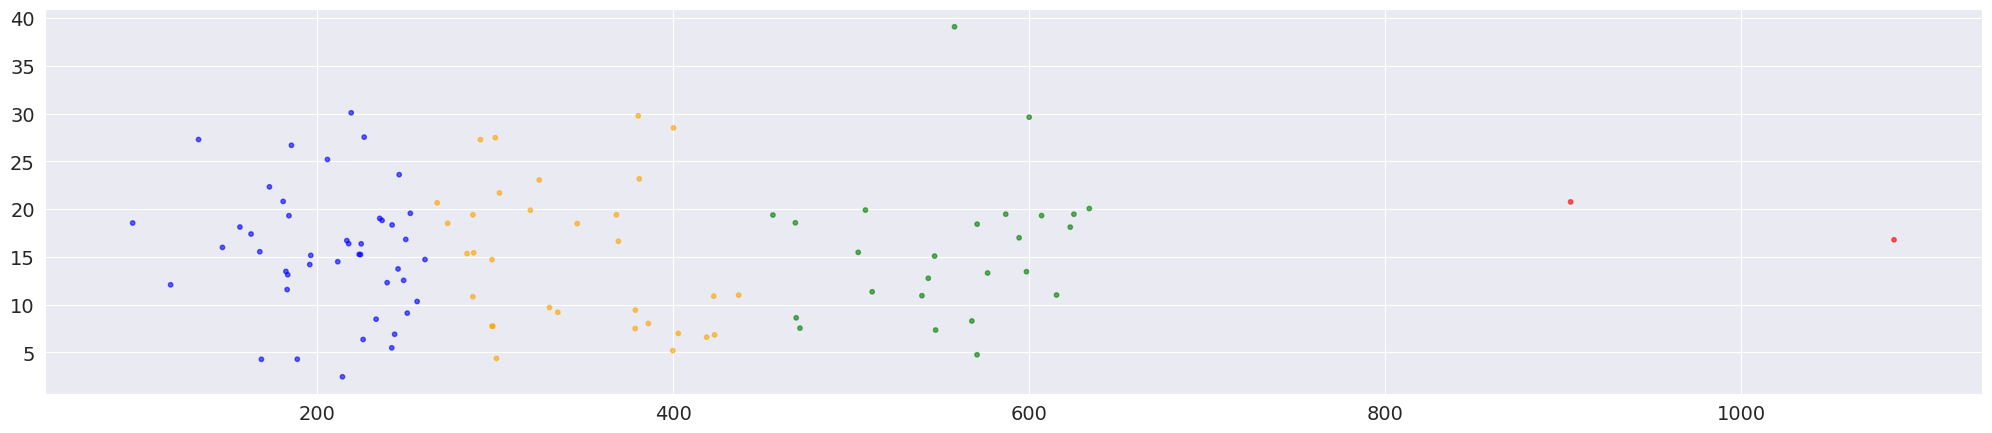

In [10]:
# plot clusters
colors = ['orange','blue', 'red', 'green']
plt.scatter(demand_top_sku_pivot[1], demand_top_sku_pivot[2], c=[colors[x] for x in cluster_labels], alpha = 0.6, s=10)

## One more research regarding ML pipeline segmentation
https://github.com/aromanenko/ML-pipeline-segmentation/tree/Ian

# Intermittent Demand Forecasting Models
Times Series with intermittent-demand-pattern contains non-zero actual values in random time points (non-zero actual values occur occasionaly).


<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/IntermittentExample.PNG?raw=true">
<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/IntermittentExample2.PNG?raw=true">

## Intermittent Demand Time Series model

$$ y_t = x_t\cdot z_t +\varepsilon_t$$

   - $x_t$ - random variable (1 or 0) to have non-zero actual value       
   - $z_t$ - actual volume


**Note:**
 - sometimes intermittent time series are classified to more classes https://frepple.com/blog/demand-classification/
 - don't confuse intermittent and highly-causal driven time series:
     -- we don't know time

## Croston Model
<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/CrostonIdea.PNG?raw=true">

**Croston Algorithm for Time Series Forecasting**

$$ \hat{y}_{t+1}=\hat z_t/\hat{n}_t$$
where
$$ \hat z_t = \begin{cases}z_{t-1}, & y_t==0 \\ \alpha\cdot{y_t}+(1-\alpha) z_{t-1}, & y_t <>0 \end{cases}$$

$$ \hat{n}_t = \begin{cases}\hat{n}_t, & y_t==0 \\ \beta\cdot{\color{red}{n_t}}+(1-\beta) \hat{n}_{t-1}, & y_t <>0 \end{cases}$$

$\alpha$ - smoothing parameter for time level value
$\beta$ - smoothing parameter for 0-intervals length forecasting

<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/CrostonIdea2.PNG?raw=true">


**Example of Realization**
- https://towardsdatascience.com/croston-forecast-model-for-intermittent-demand-360287a17f5f

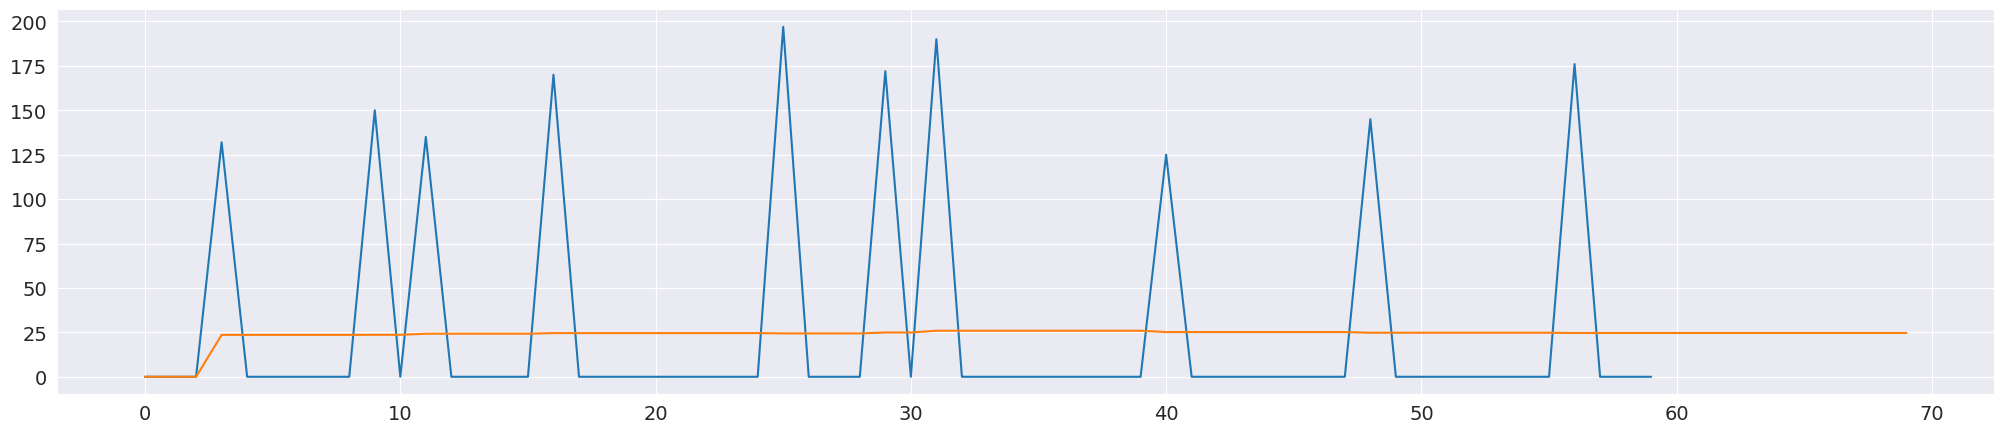

In [11]:
!pip install croston
from croston import croston
import random

a = np.zeros(50)
val = np.array(random.sample(range(100,200), 10))
idxs = random.sample(range(50), 10)

ts = np.insert(a, idxs, val)

fit_pred = croston.fit_croston(ts, 10,'original')

yhat = np.concatenate([fit_pred['croston_fittedvalues'], fit_pred['croston_forecast']])

plt.plot(ts)
plt.plot(yhat)

# TS Segmentation to define TS-Forecasting Pipeline


**Question**
 * What is the main reason of overfitting problem?
   <!-- Too big complexity of the algorithm. -->
 * Can you describe complexity of ESM/ARIMA/Intermittent Models?
    <!-- The more hidden components including drivers we need to estimate by the algorithm the more complicated the algorithm is. -->
 * Is it possible to decrease complexity of train ts-algorithm assuming that we use all known models in the training process ESM/ARIMA/Intermittent models?
  <!-- Idea: let's exclude excessive models from training set of models -->


## One more way how to select ts-models family before training process

<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/ts_pipeline_segmentation.png?raw=true' width = 800pt>

**Правило сопоставления сегмента TS и семейства моделей, учесвующих в обучении**

|   Сегмент     |   Семейство алгоритмов   |
|-------------------------|----------------|
|RETIRED                               |zero-model (прогноз =0)|
|LOW_VOLUME                           |Simple ES|
|INSEASON_NON_INTERMITTENT|           Seasonal ES and ARIMA|
|INSEASON_INTERMITTENT    |         Croston model|
|YEAR_ROUND_SEASONAL                   |Seasonal ES and ARIMA|
|YEAR_ROUND_SEASONAL_INTERMITTENT      |Croston Model|
|YEAR_ROUND_NOT_SEASONAL               |not-seasonal ES annd ARIMA|
|YEAR_ROUND_INTERMITTENT                |Croston Model|
|Short                |ML (out of the scope)|

Detailes see here: https://github.com/aromanenko/ts-segmentation

# Building Time Series Forecastability Index
Those Time Series that have about the same accuracy level should have the same $\color{red}{Forecastability~Index}$.



<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Forecastability%20Index.png?raw=true' width = 500pt>

Techniques to do it
* STL decomposition (detecting trend and seasonality) https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html

* ABC splitting (to segment by Demand Velocity and Demand Variability) https://pypi.org/project/abc-analysis/

or <a href = 'https://excel.city/2015/01/methods-of-classification-in-abc-analysis/'>more advanced tecniques </a>

* Intermittency time series tests


In [12]:
!pip install abc_analysis

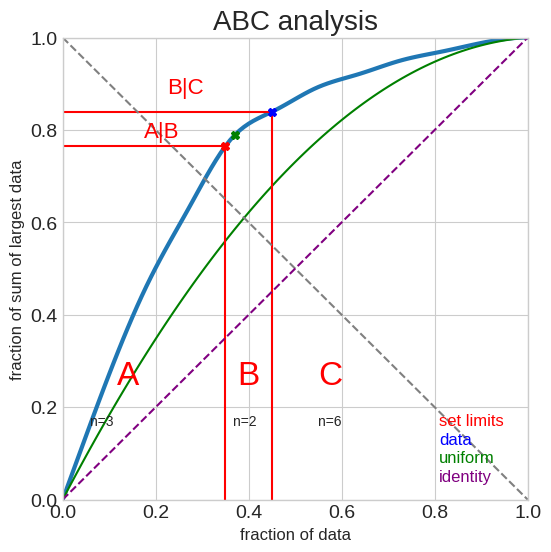

In [13]:
import abc_analysis
from abc_analysis import abc_analysis, abc_plot

# Perform an ABC analysis with plotting
dctAnalysis = abc_analysis([1, 15, 25, 17, 2, 3, 5, 6, 2, 3, 22], True)

In [18]:
# ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
# ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
# ts_retail.set_index(['Date'], inplace=True)

ts_id_columns = ['Store_id', 'SKU_id']
# ts_retail.head()

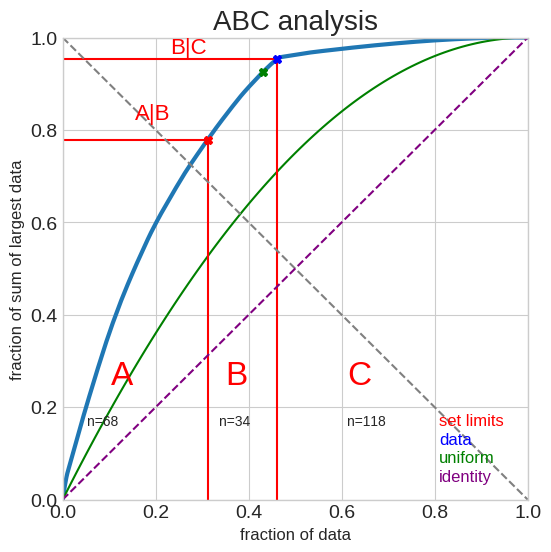

In [19]:
# split TS by Demand Volume
ts_mean_values = ts_retail.groupby(ts_id_columns)['Demand'].mean()

# Plot saved results of an ABC analysis
ts_demand_abc  = abc_analysis(ts_mean_values.fillna(0), True)


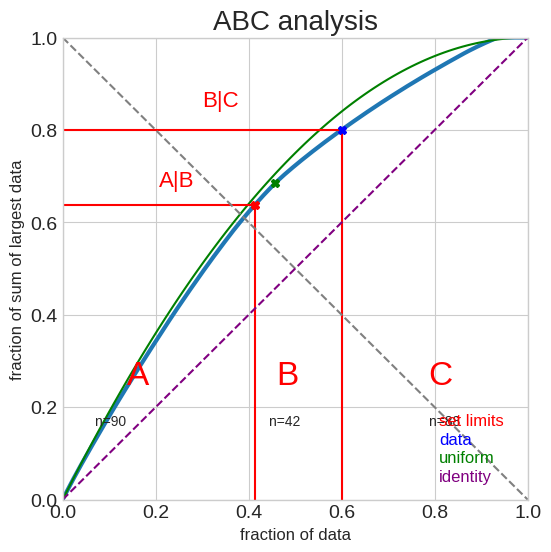

In [20]:
# split TS by Coefficient of Volatility (CV)
ts_cv_values = ts_retail.groupby(ts_id_columns)['Demand'].std().fillna(0).div(ts_retail.groupby(ts_id_columns)['Demand'].mean().fillna(1))

# Plot saved results of an ABC analysis
ts_demand_abc  = abc_analysis(ts_cv_values.fillna(0), True)

# Dynamic Time Series Warping algorithms
https://paul-mora.com/classification/time-series/clustering/python/Dynamic-Time-Warping-Explanation-and-Testing-on-Audio-and-Tabular-Data/

# Conclusion

* TS segmentation can be done by many different approaches
  - Building of ML models dimensions can be perfomed with Clustering algorithms
  - TS segmentation can be beneficial for TS algorithms training pipeline
  - Building of Forecastability groups can be done with some conservative segmentation techniques
  - DTW algorithms can be used to split time series based on profiles


# Self-check questions
1. Why ML pipeline segmentation has advantage vs one-ml-model pipeline?
2. What is intermittent-demand-patterned time series?
3. Describe how croston model works